# O Problema das Oito Rainhas

Esse notebook demonstra o `GASolver` usando-o para resolver o Problema das Oito Rainhas.
O problema consiste em colocoar oito rainhas num tabuleiro de xadrez de forma que
nenhuma delas possa atacar a outra.

Para resolver um problema utilizando algoritmos genéticos e, por consequência o `GASolver`,
algumas questões precisam ser definidas:

    1. Como representar uma possível solução, normalmente chamado de 'indivíduo'?
    2. Como realizar uma *mutação* em um indivíduo?
    3. Como realizar o *cruzamento* de dois indivíduos?
    4. Como determinar o quão "perto" da solução um indivíduo está,
       normalmente chamado de "_fitness_"?
    5. Como definir o valor de "_fitness_" máximo e indica que o problema é
       resolvido por um indivíduo?

## Expressando um Indivíduo

No caso do Problema das Oito Rainhas, podemos lançar mão de certas características
das regras e do jogo de xadrez:

    1. O tabuleiro é 8x8
    2. Rainhas atacam toda a sua coluna
    3. Rainhas atacam toda a sua linha
    
Dessas observações, podemos concluir com segurança que uma solução não terá
duas ou mais rainhas na mesma linha nem na mesma coluna. Seja lá como for
a solução, as rainhas não podem compartilhar esses atributos.

Sendo assim, podemos representar um indivíduo - e por consequência uma
possível solução - como sendo simplesmente uma lista de 8 números
inteiros de 1 à 8. Cada posição na lista representa uma coluna
e o número na posição indica a linha na qual existe uma rainha.

Por exemplo, em `[3, 2, 5]`, temos 3 rainhas:

    1. Na coluna 1, linha 3
    2. Na coluna 2, linha 2
    3. Na coluna 3, linha 5
    
Note que no problema real, teremos sempre 8 números.

## Realizando uma Mutação

Existem diversas formas que poderíamos recombinar uma lista de 8 números
para fabricar uma outra lista de 8 números. No caso, vou optar por
uma solução que procede assim:

    1. Um índice entre [1, 6) é escolhido
    2. Tudo o que tiver na lista depois desse índice é invertido
    
```
[1, 2, 3, 4 | 5, 6, 7, 8] -> [1, 2, 3, 4, 8, 7, 5, 6]
            ^
            |
          mutação
```

Por que entre 1 e 6? Isso é uma escolha arbitrária! Fiz nessa faixa porque
gostaria que sempre _alguma coisa_ fosse mutada mas que também _alguma coisa_
ficasse igual. Se fosse possível sortear 0, seria também possível mudar tudo.
Por outro lado se fosse possível sortear 6 ou mais, muito pouco da solução
original iria sobrar. Escolhi esses valores para tentar equilibrar.

Adicionalmente, em 50% das vezes, a mutação ira modificar o último
elemento para um elemento aleatório.

In [2]:
from random import randint, random
def board_mutation(board):
    """
    Pick a random position in the middle of board and flips it
    [1, 2, 3, 4 | 5, 6, 7, 8] -> [1, 2, 3, 4, 8, 7, 5, 6]
                ^
         mutation point
    """
    board = list(board)
    point = randint(1, 6)
    board[point:] = board[point:][::-1]
    
    if random() > 0.5:
        board[-1] = randint(1, 8)
        
    return tuple(board)

## Cruzando Indivíduos

Da mesma forma que podemos definir uma mutação de muitas formas diferentes,
também podemos inventar diversas maneiras de criar um novo indivíduo com
base em outros dois que já existem. Decidi proceder de uma maneira
parecida com a mutação:

    1. Um índice aleatório é escolhido entre 1 <= x < 6
    2. Até esse índice, o filho será igual ao ancestral A
    3. Desse índice em diante, o filho será igual ao ancestral B

Assim como na mutação, poderíamos ter feito de diversas formas diferentes,
essa foi uma escolha arbitrária pensando em como fazer com que os dois
ancestrais contribuam para o descendente.

In [3]:
from random import shuffle, random
def crossover(board_a, board_b):
    """
    Picks a random point in the board. The sibling will be equal to board_a
    up until that point and board_b to the rest.
    """

    point = randint(1, 6)
    result = list(board_a[:point])
    second_half = list(board_b[point:])
    result.extend(second_half)

    return tuple(result)

In [4]:
crossover([1,2,3,4,5,6,7,8], [4,5,6,1,2,3,7,8])

(1, 2, 3, 4, 5, 6, 7, 8)

Vou adicionar uma outra função de crossover mais "esperta", a `crossover_plus`. Ela vai fazer duas coisas de diferente:

    1. 50% das vezes ela vai embaralhar a parte do filho que vem do ancestral B
    2. Nós sabemos que uma solução não pode ter de fato números repetidos. Essa
       solução vai tentar 10x gerar um filho sem repetições. Se não conseguir,
       vai retornar o que tiver

In [6]:
from random import shuffle, random
def crossover_plus(board_a, board_b):
    """
    Picks a random point in the board. The sibling will be equal to board_a
    up until that point and board_b to the rest.
    """
    result = []
    tries = 0
    # Trimming the ends so that each parent will have a part
    while len(set(result)) != 8 and tries < 10:
        tries += 1
        point = randint(1, 6)
        result = list(board_a[:point])
        second_half = list(board_b[point:])
    
        if random() > 0.5:
            shuffle(second_half)
        
        result.extend(second_half)
    
    return tuple(result)

## Determinando o _fitness_ e o Valor Ótimo

No caso do Problema das Oito Rainhas, podemos definir o quão boa uma
solução é com base no _número de pares de rainhas que não conseguem
se atacar_. Como queremos que _nenhuma_ rainha consiga se atacar,
o valor ótimo é igual à 28, o número de combinações dois-por-dois
que conseguimos fazer com 8 elementos sem repetição.

Determinar se duas rainhas se atacam envolve determinar 3 itens,
se as rainhas estão na mesma:

    1. Linha
    2. Coluna
    3. Diagonal
    
Determinar as duas primeiras condições é fácil, a terceira
é um pouco mais elaborada. Para dividir responsabilidades
e garantir que cada pedaço de código seja bem contido,
primeiro vou definir uma função que determinar quais
são as posições no tabuleiro nas diagonais de uma
determinada posição:

In [7]:
from functools import lru_cache


@lru_cache(maxsize=64)
def diagonals(line, column):
    """
    Returns a list containing the positions in the
    diagonals of a given square
    
    >>> attacking_positions(8, 1)
    [(7, 2), (6, 3), (5, 4), (4, 5), (3, 6), (2, 7), (1, 8)]
    """
    result = []

    def check_bounds(line, column):
        """
        Checks if a given position is valid. That is, is within the board boundaries
        """
        return (0 < line < 9) and (0 < column < 9)

    def diagonal(line, column, n=1):
        """
        Calculates the diagonals of a given position
        """
        for x in range(1, 9):
            if n == 1:
                line_ = line + x
                column_ = column + x
            elif n == 2:
                line_ = line - x
                column_ = column + x
            elif n == 3:
                line_ = line - x
                column_ = column - x
            elif n == 4:
                line_ = line + x
                column_ = column - x

            if check_bounds(line_, column_):
                yield (line_, column_)

    diagonal1 = list(diagonal(line, column))
    diagonal2 = list(diagonal(line, column, n=2))
    diagonal3 = list(diagonal(line, column, n=3))
    diagonal4 = list(diagonal(line, column, n=4))

    result.extend(diagonal1)
    result.extend(diagonal2)
    result.extend(diagonal3)
    result.extend(diagonal4)
    return result

In [8]:
diagonals(8, 1)

[(7, 2), (6, 3), (5, 4), (4, 5), (3, 6), (2, 7), (1, 8)]

Definida a função que computa as diagonais, podemos escrever uma função `attacks`,
que dada duas rainhas retorna `True` ou `False` se elas podem se atacar ou não.

In [9]:
def attacks(queen_a, queen_b):
    """
    Returns true if those queens are in reachable positions from each other
    
    Args:
        queen_a, queen_b (tuple): a (line, column) tuple representing their positions
        
    >>> attacks((8,1), (6,3))
    True
    >>> attacks((6,3), (8, 1))
    True
    
    """

    return (
        queen_a[0] == queen_b[0]
        or queen_a[1] == queen_b[1]
        or queen_a in diagonals(*queen_b)
    )

In [10]:
attacks((8, 1), (6, 3))

True

Finalmente, podemos definir uma função que dado um tabuleiro,
retorna o número de pares de rainhas que podem se atacar

In [11]:
from itertools import combinations

def count_non_attacking_queens(board):
    """
    Given an integer list of 8 items, each position representing a column on a chess board
    and each number representing a line in that column where there's a queen, returns
    the number of non attacking queens
    """
    queens = [(line, column + 1) for column, line in enumerate(board)]
    queen_combos = combinations(queens, 2)
    
    non_attacking = 0
    
    for queen_a, queen_b in queen_combos:
        non_attacking += 1 if not attacks(queen_a, queen_b) else 0
    return non_attacking

In [12]:
count_non_attacking_queens([8,6,4,2,7,5,3,1])

27

Vamos criar uma função adicional que podemos usar como fitness. Essa função vai descontar repetições que um pai possa ter:

In [14]:
def goal(board):
    non_attacking = count_non_attacking_queens(board)
    repetitions = 8 - len(set(board))
    return max(non_attacking - repetitions * 10, 0.001)

## Usando o `GASolver`

Com todas essas informações definidas, podemos usar o `GASolver` para resolver o problema das Oito Rainhas.
Vou definir a população inicial como sendo 4 tabuleiros aleatórios

In [15]:
import ga_solver
from ga_solver import GASolver
from ga_solver.pop_selectors import roullete

In [16]:
ga_solver.__version__

'0.1.2'

Com essa população, podemos instanciar um `GASolver` usando o algoritmo de Roleta para seleção.

In [33]:
from random import sample
initial_pop = [tuple(sample(range(1, 9), k=8)) for _ in range(4)]

In [34]:
eight_queen_solver = GASolver(
    initial_pop,
    goal=goal,
    target_value=28,
    mutation=board_mutation,
    prob_mutation=0.8,
    crossover_=crossover,
    selector=roullete,
    selection_rate=0.5,
    min_select=2,
    max_steps=10000,
)

In [35]:
fits = []
while not eight_queen_solver.solution_found:
    # print(f"Population is {eight_queen_solver.population}")
    fits.append(eight_queen_solver.best_fit[1])
    next(eight_queen_solver)
print(f"Found the solution in {eight_queen_solver.steps} steps")

Found the solution in 82 steps


Como podemos ver, o `solver` consegue responder. Agora vamos comparar as diferentes estratégias que tivemos. Para isso, vou criar uma função que recebe um `solver` e retorna o tanto de passos que ele levou:

In [72]:
def solve(solver, initial_pop=None):
    if not initial_pop:
        initial_pop = [tuple(sample(range(1, 9), k=8)) for _ in range(4)]
        
    solver.steps = 0
    solver.population = initial_pop
    
    while not solver.solution_found:
        try:
            next(solver)
        except:
            return -1
    return solver.steps
    

Agora vamos executar nosso solver 10x:

In [73]:
steps = [solve(eight_queen_solver, initial_pop) for _ in range(10)]

In [74]:
steps

[559, 1481, -1, 1399, 67, 2542, 1834, 4, 1142, 1880]

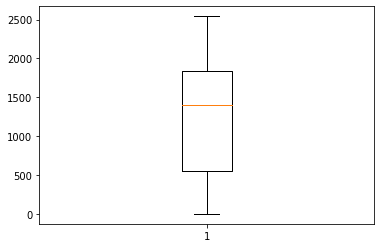

In [75]:
plt.boxplot([x for x in steps if x != -1])
plt.show()

Como podemos ver, houve uma grande variância no número de passos necessários. Em uma instância, o solver nem conseguiu resolver o problema

Vamos ver agora a performance usando o `crossover_plus`:

In [76]:
eqs_cross_plus = GASolver(
    initial_pop,
    goal=goal,
    target_value=28,
    mutation=board_mutation,
    prob_mutation=0.8,
    crossover_=crossover_plus,
    selector=roullete,
    selection_rate=0.5,
    min_select=2,
    max_steps=10000,
)

In [77]:
steps = [solve(eqs_cross_plus, initial_pop) for _ in range(10)]

Note que estou usando a mesma variável `initial_pop` em todos, para garantir que todos os problemas partam da mesma solução inicial

In [78]:
steps

[9289, -1, 780, 3910, 4380, 1511, 1, 483, 627, 543]

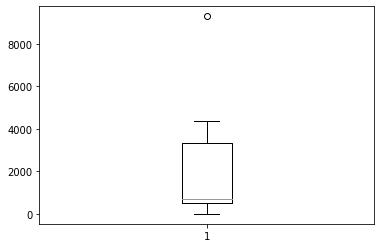

In [79]:
plt.boxplot(steps)
plt.show()

Tivemos uma performance melhor com o `crossover_plus`! Vamos avaliar agora o `crossover` normal usando como função de objetivo apenas o número de pares que não se atacam, sem penalizar repetições:

In [59]:
eqs_repeat = GASolver(
    initial_pop,
    goal=count_non_attacking_queens,
    target_value=28,
    mutation=board_mutation,
    prob_mutation=0.8,
    crossover_=crossover,
    selector=roullete,
    selection_rate=0.5,
    min_select=2,
    max_steps=10000,
)

In [60]:
steps = [solve(eqs_repeat, initial_pop) for _ in range(10)]

In [61]:
steps

[1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

Sem a punição por repetição e com crossover simples, nenhuma solução foi encontrada e 10k passos! Vamos adicionar o `crossover_plus`

**Nota**: Se você reexecutar esse notebook em sua máquina, seus resultados provavelmente serão diferentes por conta da aleatoriedade que existe no comportamento

In [62]:
eqs_repeat_plus = GASolver(
    initial_pop,
    goal=count_non_attacking_queens,
    target_value=28,
    mutation=board_mutation,
    prob_mutation=0.8,
    crossover_=crossover_plus,
    selector=roullete,
    selection_rate=0.5,
    min_select=2,
    max_steps=10000,
)

In [63]:
steps = [solve(eqs_repeat_plus, initial_pop) for _ in range(10)]

In [64]:
steps

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

Mais uma vez, nenhuma solução encontrada!

Vou definir agora um `crossover` mais agressivo: quando um descendente com repetição for encontrado, ele vai mutar o filho algumas vezes na tentativa de torná-lo viável:

In [65]:
def crossover_mut(board_a, board_b):
    steps = 0
    sibling = crossover(board_a, board_b)
    
    while len(set(sibling)) != 8 and steps < 10:
        sibling = board_mutation(sibling)
        steps += 1
        
    return sibling

Vamos ver se esse crossover tem mais sucesso:

In [66]:
eqs_repeat_cross_mut = GASolver(
    initial_pop,
    goal=count_non_attacking_queens,
    target_value=28,
    mutation=board_mutation,
    prob_mutation=0.8,
    crossover_=crossover_mut,
    selector=roullete,
    selection_rate=0.5,
    min_select=2,
    max_steps=10000,
)

In [67]:
steps = [solve(eqs_repeat_plus, initial_pop) for _ in range(10)]

In [68]:
steps

[-1, -1, 1, -1, -1, -1, -1, -1, -1, -1]

Ainda sem sucesso! Vamos avaliar esse `crossover_mut` com a função que penaliza repetições:

In [69]:
eqs_cross_mut = GASolver(
    initial_pop,
    goal=goal,
    target_value=28,
    mutation=board_mutation,
    prob_mutation=0.8,
    crossover_=crossover_mut,
    selector=roullete,
    selection_rate=0.5,
    min_select=2,
    max_steps=10000,
)

In [70]:
steps = [solve(eqs_repeat_plus, initial_pop) for _ in range(10)]

In [71]:
steps

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

Aparentemente essa função de crossover não foi benéfica!

Os únicos `solvers` que conseguiram terminar o problema até agora usaram uma função de `fitness` que penaliza repetições e crossovers diferentes. O segundo, que levou menos passos em média pra chegar na solução usa de uma lógica mais elaborada para tentar gerar sucessores mais viáveis. Porém, como saber o impacto que essa solução tem no tempo de execução?

Para fazer esse benchmark, vamos usar a função mágica `%timeit`, do Jupyter:

In [86]:
%timeit -n 20 -r 1 solve(eight_queen_solver, initial_pop)

1.26 s ± 0 ns per loop (mean ± std. dev. of 1 run, 20 loops each)


In [87]:
%timeit -n 20 -r 1 solve(eqs_cross_plus, initial_pop)

962 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 20 loops each)


E num teste com 20 repetições, o `crossover_plus` foi um pouco mais rápido!